In [2]:
## STANDARD PYTHON LIBS
import os
import re
import sys
import cv2
import PIL
import math
import time
import random
import scipy.misc
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## ADDING TO ROOT
ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(ROOT_DIR)

## CUSTOM LIBS
from src.model import log
import src.utils as utils
import src.model as modellib
from src.config import Config
import src.visualize as visualize

# GPU LIBS
import keras
import tensorflow as tf

print ('TF : ', tf.__version__, '  Keras : ', keras.__version__)

if utils.check_gpu(verbose=0):
    pass
else:
    sys.exit(1)

TF :  1.6.0   Keras :  2.1.4

 =========== nvidia-smi ========== 
Query for existing PIDs using GPU : nvidia-smi --query-compute-apps=pid --format=csv,noheader
 --->  ['25566']
Damn son! You gotta kill the PIDS - ['25566'] and then run nvidia-smi -r under root
 ---> Then come back and run this script again


SystemExit: 1

/home/play/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2918: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [3]:
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, 'demo', 'model', "mask_rcnn_coco.h5")
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

In [4]:
import os, sys, random, math
import numpy as np

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), '../'))
sys.path.append(ROOT_DIR)

import src.utils as utils
from src.config import Config

class ShapesConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    
    # Give the configuration a recognizable name
    NAME = "shapes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 10

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 1

config = ShapesConfig()
# config.display()

In [5]:
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [6]:
class ShapesDataset(utils.Dataset):
    """Generates the shapes synthetic dataset. The dataset consists of simple
    shapes (triangles, squares, circles) placed randomly on a blank surface.
    The images are generated on the fly. No file access required.
    """

    def load_shapes(self, count, height, width):
        """Generate the requested number of synthetic images.
        count: number of images to generate.
        height, width: the size of the generated images.
        """
        # Add classes
        self.add_class("shapes", 1, "square")
        self.add_class("shapes", 2, "circle")
        self.add_class("shapes", 5, "triangle")

        # Add images
        # Generate random specifications of images (i.e. color and
        # list of shapes sizes and locations). This is more compact than
        # actual images. Images are generated on the fly in load_image().
        for i in range(count):
            bg_color, shapes = self.random_image(height, width)
            self.add_image("shapes", image_id=i, path=None,
                           width=width, height=height,
                           bg_color=bg_color, shapes=shapes)
            # for mapillary I shall traverse the train directory with image/instance sub-dirs.
            # **kwargs = masks = [], bbs = [], 

    def load_image(self, image_id):
        """Generate an image from the specs of the given image ID.
        Typically this function loads the image from a file, but
        in this case it generates the image on the fly from the
        specs in image_info.
        """
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        image = np.ones([info['height'], info['width'], 3], dtype=np.uint8)
        image = image * bg_color.astype(np.uint8)
        for shape, color, dims in info['shapes']:
            image = self.draw_shape(image, shape, dims, color)
        return image

    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "shapes":
            return info["shapes"]
        else:
            super(self.__class__).image_reference(self, image_id)

    def load_mask(self, image_id):
        """Generate instance masks for shapes of the given image ID.
        """
        info = self.image_info[image_id]
        shapes = info['shapes']
        count = len(shapes)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        for i, (shape, _, dims) in enumerate(info['shapes']):
            mask[:, :, i:i+1] = self.draw_shape(mask[:, :, i:i+1].copy(),
                                                shape, dims, 1)
        # Handle occlusions
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        return mask, class_ids.astype(np.int32)

    def draw_shape(self, image, shape, dims, color):
        """Draws a shape from the given specs."""
        # Get the center x, y and the size s
        x, y, s = dims
        if shape == 'square':
            cv2.rectangle(image, (x-s, y-s), (x+s, y+s), color, -1)
        elif shape == "circle":
            cv2.circle(image, (x, y), s, color, -1)
        elif shape == "triangle":
            points = np.array([[(x, y-s),
                                (x-s/math.sin(math.radians(60)), y+s),
                                (x+s/math.sin(math.radians(60)), y+s),
                                ]], dtype=np.int32)
            cv2.fillPoly(image, points, color)
        return image

    def random_shape(self, height, width):
        """Generates specifications of a random shape that lies within
        the given height and width boundaries.
        Returns a tuple of three valus:
        * The shape name (square, circle, ...)
        * Shape color: a tuple of 3 values, RGB.
        * Shape dimensions: A tuple of values that define the shape size
                            and location. Differs per shape type.
        """
        # Shape
        shape = random.choice(["square", "circle", "triangle"])
        # Color
        color = tuple([random.randint(0, 255) for _ in range(3)])
        # Center x, y
        buffer = 20
        y = random.randint(buffer, height - buffer - 1)
        x = random.randint(buffer, width - buffer - 1)
        # Size
        s = random.randint(buffer, height//4)
        return shape, color, (x, y, s)

    def random_image(self, height, width):
        """Creates random specifications of an image with multiple shapes.
        Returns the background color of the image and a list of shape
        specifications that can be used to draw the image.
        """
        # Pick random background color
        bg_color = np.array([random.randint(0, 255) for _ in range(3)])
        # Generate a few random shapes and record their
        # bounding boxes
        shapes = []
        boxes = []
        N = random.randint(1, 4)
        for _ in range(N):
            shape, color, dims = self.random_shape(height, width)
            shapes.append((shape, color, dims))
            x, y, s = dims
            boxes.append([y-s, x-s, y+s, x+s])
        # Apply non-max suppression wit 0.3 threshold to avoid
        # shapes covering each other
        keep_ixs = utils.non_max_suppression(np.array(boxes), np.arange(N), 0.3)
        shapes = [s for i, s in enumerate(shapes) if i in keep_ixs]
        return bg_color, shapes

In [8]:
# Training dataset
dataset_train = ShapesDataset()
dataset_train.load_shapes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = ShapesDataset()
dataset_val.load_shapes(5, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

(128, 128, 3) [2 2 2] [0 1]


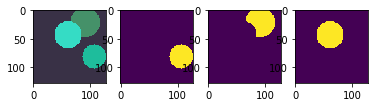

In [9]:
image_ids = np.random.choice(dataset_train.image_ids, 10)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print (mask.shape, class_ids, np.unique(mask[:,:,0]))
    w,h,d = mask.shape
    if d >= 3: 
        f, axarr = plt.subplots(1,4)
        axarr[0].imshow(image)
        axarr[1].imshow(mask[:,:,0])
        axarr[2].imshow(mask[:,:,1])
        axarr[3].imshow(mask[:,:,2])
        break
    # visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names, limit=5)

In [10]:
print (config.IMAGE_SHAPE)
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')

[128 128   3]

--------------------------
[play] rois : (8, ?, ?)
[play] target_class_ids : (8, ?)
[play] target_bbox : Tensor("proposal_targets/target_bbox:0", shape=(8, ?, ?), dtype=float32)
[play] target_mask : Tensor("proposal_targets/target_mask:0", shape=(8, ?, ?, ?), dtype=float32)
mrcnn_mask : Tensor("mrcnn_mask/Reshape_1:0", shape=(?, 32, 28, 28, 4), dtype=float32)


ResourceExhaustedError: OOM when allocating tensor with shape[1,1,256,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: res4q_branch2c/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=1417427, _device="/job:localhost/replica:0/task:0/device:GPU:0"](res4a_branch2c/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'res4q_branch2c/random_uniform/RandomUniform', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/play/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/play/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/play/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/play/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/play/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/play/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/play/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/play/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/play/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/play/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/play/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-ed2b14853b4c>", line 2, in <module>
    model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)
  File "/home/play/playment/production/Mask_RCNN/src/model.py", line 1770, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "/home/play/playment/production/Mask_RCNN/src/model.py", line 1826, in build
    _, C2, C3, C4, C5 = resnet_graph(input_image, "resnet101", stage5=True)
  File "/home/play/playment/production/Mask_RCNN/src/model.py", line 173, in resnet_graph
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block=chr(98 + i))
  File "/home/play/playment/production/Mask_RCNN/src/model.py", line 105, in identity_block
    use_bias=use_bias)(x)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 590, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/convolutional.py", line 138, in build
    constraint=self.kernel_constraint)
  File "/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 411, in add_weight
    weight = K.variable(initializer(shape),
  File "/usr/local/lib/python3.5/dist-packages/keras/initializers.py", line 217, in __call__
    dtype=dtype, seed=self.seed)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 3829, in random_uniform
    dtype=dtype, seed=seed)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/random_ops.py", line 244, in random_uniform
    shape, dtype, seed=seed1, seed2=seed2)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_random_ops.py", line 435, in _random_uniform
    name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[1,1,256,1024] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: res4q_branch2c/random_uniform/RandomUniform = RandomUniform[T=DT_INT32, dtype=DT_FLOAT, seed=87654321, seed2=1417427, _device="/job:localhost/replica:0/task:0/device:GPU:0"](res4a_branch2c/random_uniform/shape)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]
print (model_path)

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

/home/play/playment/production/Mask_RCNN/logs/shapes20180309T1011/mask_rcnn_shapes_0001.h5
Loading weights from  /home/play/playment/production/Mask_RCNN/logs/shapes20180309T1011/mask_rcnn_shapes_0001.h5


In [12]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

results = model.detect([original_image], verbose=1)

# for i, result in enumerate(results):
#     print ('\nImage ', i+1, ' : ', result['rois'], result['class_ids'])

r = results[0]
print (r['class_ids'], dataset_val.class_names)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

# visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
#                             dataset_train.class_names, figsize=(8, 8))

original_image           shape: (128, 128, 3)         min:   15.00000  max:  231.00000
image_meta               shape: (12,)                 min:    0.00000  max:  128.00000
gt_class_id              shape: (1,)                  min:    2.00000  max:    2.00000
gt_bbox                  shape: (1, 4)                min:   12.00000  max:   64.00000
gt_mask                  shape: (128, 128, 1)         min:    0.00000  max:    1.00000
 ---> Processing 1 images
 ----> image             shape: (128, 128, 3)         min:   15.00000  max:  231.00000
 ----> molded_images     shape: (1, 128, 128, 3)      min:  -88.90000  max:  114.20000
 ----> image_metas       shape: (1, 12)               min:    0.00000  max:  128.00000


FailedPreconditionError: Attempting to use uninitialized value bn3a_branch2c_1/beta
	 [[Node: bn3a_branch2c_1/beta/read = Identity[T=DT_FLOAT, _class=["loc:@bn3a_branch2c_1/beta"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](bn3a_branch2c_1/beta)]]
	 [[Node: mrcnn_detection/ExpandDims_2/_2869 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3499_mrcnn_detection/ExpandDims_2", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

Caused by op 'bn3a_branch2c_1/beta/read', defined at:
  File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/play/.local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/play/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 112, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 345, in run_forever
    self._run_once()
  File "/usr/lib/python3.5/asyncio/base_events.py", line 1312, in _run_once
    handle._run()
  File "/usr/lib/python3.5/asyncio/events.py", line 125, in _run
    self._callback(*self._args)
  File "/home/play/.local/lib/python3.5/site-packages/tornado/platform/asyncio.py", line 102, in _handle_events
    handler_func(fileobj, events)
  File "/home/play/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/play/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/play/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/play/.local/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/play/.local/lib/python3.5/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/play/.local/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/play/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2728, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/play/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2850, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/play/.local/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-5e52e2c44a24>", line 10, in <module>
    model_dir=MODEL_DIR)
  File "/home/play/playment/production/Mask_RCNN/src/model.py", line 1770, in __init__
    self.keras_model = self.build(mode=mode, config=config)
  File "/home/play/playment/production/Mask_RCNN/src/model.py", line 1826, in build
    _, C2, C3, C4, C5 = resnet_graph(input_image, "resnet101", stage5=True)
  File "/home/play/playment/production/Mask_RCNN/src/model.py", line 165, in resnet_graph
    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
  File "/home/play/playment/production/Mask_RCNN/src/model.py", line 141, in conv_block
    x = BatchNorm(axis=3, name=bn_name_base + '2c')(x)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 590, in __call__
    self.build(input_shapes[0])
  File "/usr/local/lib/python3.5/dist-packages/keras/layers/normalization.py", line 115, in build
    constraint=self.beta_constraint)
  File "/usr/local/lib/python3.5/dist-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/usr/local/lib/python3.5/dist-packages/keras/engine/topology.py", line 414, in add_weight
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py", line 392, in variable
    v = tf.Variable(value, dtype=tf.as_dtype(dtype), name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 233, in __init__
    constraint=constraint)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/variables.py", line 381, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/array_ops.py", line 131, in identity
    return gen_array_ops.identity(input, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gen_array_ops.py", line 2051, in identity
    "Identity", input=input, name=name)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 3271, in create_op
    op_def=op_def)
  File "/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/ops.py", line 1650, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value bn3a_branch2c_1/beta
	 [[Node: bn3a_branch2c_1/beta/read = Identity[T=DT_FLOAT, _class=["loc:@bn3a_branch2c_1/beta"], _device="/job:localhost/replica:0/task:0/device:GPU:0"](bn3a_branch2c_1/beta)]]
	 [[Node: mrcnn_detection/ExpandDims_2/_2869 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_3499_mrcnn_detection/ExpandDims_2", tensor_type=DT_INT64, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]


In [14]:
original_image.shape

(128, 128, 3)